## 计算单核细胞计数性状的lcczscore【单细胞数据是BMMC，血液相关细胞】

In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import random
import numpy as np
import scanpy as sc
import math
import time


import warnings
# 禁用所有警告
warnings.filterwarnings("ignore")

In [2]:
# 读取 单细胞表达CSV 文件
non_zero_genes_df = pd.read_csv('E:/00_CeSOP/data/simulation/Seu_Hema_non_zero_genes.csv', index_col=0)
# 查看前几行数据
print(non_zero_genes_df.head())

                                                                           Genes
Cell                                                                            
CD34_32_R5:AAACCTGAGTATCGAA-1  FAM41C, ISG15, SDF4, AURKAIP1, MRPL20, ATAD3B,...
CD34_32_R5:AAACCTGAGTCGTTTG-1  AURKAIP1, MRPL20, ATAD3A, SSU72, RER1, PEX10, ...
CD34_32_R5:AAACCTGGTTCCACAA-1  FAM41C, ISG15, UBE2J2, AURKAIP1, ATAD3A, SLC35...
CD34_32_R5:AAACGGGAGCTTCGCG-1  NOC2L, AURKAIP1, CCNL2, MRPL20, ATAD3A, CDK11A...
CD34_32_R5:AAACGGGAGGGAGTAA-1  ISG15, AURKAIP1, MRPL20, ATAD3C, SSU72, CDK11A...


In [3]:
'''读取背景网络'''
def openPPI(filename):
    '''
        打开PPI
        文件格式 gene1_name gene1_id gene2_name gene2_id
        返回值：网络[节点是gene name]
    '''
    G = nx.Graph()
    a=open(filename,"r")
    next(a)

    for i in a:
        n=i.strip().split("\t")
        G.add_edge(n[0],n[3])
        G.add_node(n[0])
        G.add_node(n[3])
    a.close()
    return G

G = openPPI(r"E:\00_CeSOP\data\network(process_id).txt")

In [4]:
# 计算最大连通分支
def Lcc(G,genename):
    '''
        输入图网络和一个列表，计算最大连通分支lcc
        G：图，这里图中的节点是基因name
        genename：用于计算lcc的genename列表
    '''

    g = nx.subgraph(G,genename)
    if len(genename)==0:
        largest = 0
        l = []
        return l,largest
    else:
        try:
            l = max(nx.connected_components(g),key=len)  #如果随机选取的gene没有连通分支的话，会报错，添加判断条件
            largest = len(l)     #最大联通分支
        except ValueError as e:
            l = genename[0]    # 假设genename列表中的第一个基因为最大连通分支
            largest = 1        #设置最大联通分支数为1
        return list(l),largest

In [5]:
import random
import numpy as np

def Lcc_mean(g,genelist,ran):
    '''
    每次从网络g的所有基因中随机选择genelist数量的gene，计算均值和标准差
    g:背景网络
    genelist：
    ran：随机次数
    返回：表达值之和、表达值均值的多次随机的均值和标准差
    '''

    all_genes = g.nodes()  # 背景网络中的gene

    #做随机
    l_list = []         #lcc列表
    for j in range(ran):
        black_nodes = random.sample(all_genes,len(genelist))
        l,largest_ran = Lcc(g,black_nodes)
        l_list.append(largest_ran)

    #计算lcczscore
    lcc_mean = np.mean(l_list)
    lcc_std  = np.std(l_list)

    return lcc_mean,lcc_std

In [6]:
# 计算lcczscore
def lccZscore(Lcc,lcc_mean,lcc_std):
    if lcc_std == 0:
        zscore = 0
    else:
        zscore = (Lcc - lcc_mean)/lcc_std
        zscore = round(zscore,6)
    return zscore

### 核心。外围基因

In [54]:
# 读取Monocyte Count gwas数据中基因
t = 12
# trait_coregene = list(pd.read_csv(r"E:\00_CeSOP\data\core_peri_geneset_of_49_traits\core\%s.txt"%(t+1),sep = "\t",header= None)[0])
trait_coregene = list(pd.read_csv(r"E:\00_CeSOP\data\core_peri_geneset_of_49_traits\periphery\%s.txt"%(t+1),sep = "\t",header= None)[0])
l,lcc = Lcc(G,trait_coregene)
lcc_mean,lcc_std = Lcc_mean(G,trait_coregene,10)    
lcczscore = lccZscore(lcc,lcc_mean,lcc_std)
print(lcc,lcczscore)

2697 11.736038


In [56]:
# 遍历每一个spot
result_list = []
count = 0

for cell in non_zero_genes_df.index:
    count+=1
    express_genes = non_zero_genes_df.loc[cell]["Genes"].split(', ')

    disease_express_genes = list(set(trait_coregene)&set(express_genes))
    l,lcc = Lcc(G,disease_express_genes)
    
    express_network_genelist = list(set(express_genes) & set(list(G.nodes())))   # 有表达的网络基因   
    g = nx.subgraph(G,express_network_genelist)    # 构建有表达的子网络
    lcc_mean,lcc_std = Lcc_mean(g,disease_express_genes,10)    
    lcczscore = lccZscore(lcc,lcc_mean,lcc_std)
    result_list.append([len(express_genes),len(disease_express_genes),lcc,lcczscore])
    
    print(count,cell,len(express_genes),len(disease_express_genes),lcc,lcczscore,str(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())))

df_singcell = pd.DataFrame(result_list)
df_singcell.columns = ["#expressedGenes","#expressedDiseaseGenes","lcc","lcczscore"]
df_singcell["cell"]=non_zero_genes_df.index
df_singcell.to_csv(r"E:\00_CeSOP\results\simulation\Healthy-Hematopoiesis-191120-periphery.csv", index=False)

1 CD34_32_R5:AAACCTGAGTATCGAA-1 3187 564 384 2.524539 2024-12-30 18:36:26
2 CD34_32_R5:AAACCTGAGTCGTTTG-1 1787 306 158 0.713492 2024-12-30 18:36:26
3 CD34_32_R5:AAACCTGGTTCCACAA-1 2552 459 320 2.541648 2024-12-30 18:36:26
4 CD34_32_R5:AAACGGGAGCTTCGCG-1 2191 419 291 2.835001 2024-12-30 18:36:26
5 CD34_32_R5:AAACGGGAGGGAGTAA-1 2322 429 293 2.229571 2024-12-30 18:36:27
6 CD34_32_R5:AAACGGGAGTTACGGG-1 2151 391 247 2.950573 2024-12-30 18:36:27
7 CD34_32_R5:AAACGGGCAAGTAATG-1 1199 224 92 -0.049993 2024-12-30 18:36:27
8 CD34_32_R5:AAACGGGCAAGTTCTG-1 909 162 39 -0.238559 2024-12-30 18:36:27
9 CD34_32_R5:AAACGGGCACAGACAG-1 3020 524 381 3.682133 2024-12-30 18:36:27
10 CD34_32_R5:AAACGGGGTAACGTTC-1 2343 413 270 7.470106 2024-12-30 18:36:27
11 CD34_32_R5:AAACGGGGTAGCTAAA-1 2345 408 252 1.890688 2024-12-30 18:36:28
12 CD34_32_R5:AAAGATGAGGATCGCA-1 746 126 15 -0.984091 2024-12-30 18:36:28
13 CD34_32_R5:AAAGATGAGTAGTGCG-1 2457 458 330 3.841106 2024-12-30 18:36:28
14 CD34_32_R5:AAAGATGCACGAAGCA-1 238

ValueError: The truth value of a Index is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

###  MAGMA前1000基因

In [73]:

MAGMA_genes = pd.read_excel(r"E:\文献汇报\2023\20230329 scDRS\41588_2022_1167_MOESM4_ESM.xlsx",sheet_name="ST11 MAGMA gene sets")
MAGMA_Monocyte_genes = MAGMA_genes[MAGMA_genes["TRAIT"]=="UKB_460K.blood_MONOCYTE_COUNT"]["GENESET"].values.tolist()[0]
MAGMA_Monocyte_genes_list = [item.strip().split(':')[0] for item in MAGMA_Monocyte_genes.split(',')]

l,lcc = Lcc(G,MAGMA_Monocyte_genes_list)
lcc_mean,lcc_std = Lcc_mean(G,MAGMA_Monocyte_genes_list,10)    
lcczscore = lccZscore(lcc,lcc_mean,lcc_std)
print(lcc,lcczscore)

752 9.263626


In [74]:
# 遍历每一个spot
result_list = []
count = 0

for cell in non_zero_genes_df.index:
    count+=1
    express_genes = non_zero_genes_df.loc[cell]["Genes"].split(', ')

    disease_express_genes = list(set(MAGMA_Monocyte_genes_list)&set(express_genes))
    l,lcc = Lcc(G,disease_express_genes)
    
    express_network_genelist = list(set(express_genes) & set(list(G.nodes())))   # 有表达的网络基因   
    g = nx.subgraph(G,express_network_genelist)    # 构建有表达的子网络
    lcc_mean,lcc_std = Lcc_mean(g,disease_express_genes,10)    
    lcczscore = lccZscore(lcc,lcc_mean,lcc_std)
    result_list.append([len(express_genes),len(disease_express_genes),lcc,lcczscore])
    
    print(count,cell,len(express_genes),len(disease_express_genes),lcc,lcczscore,str(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())))

df_singcell = pd.DataFrame(result_list)
df_singcell.columns = ["#expressedGenes","#expressedDiseaseGenes","lcc","lcczscore"]
df_singcell["cell"]=non_zero_genes_df.index
df_singcell.to_csv(r"E:\00_CeSOP\results\simulation\Healthy-Hematopoiesis-191120-MAGMA.csv", index=False)

1 CD34_32_R5:AAACCTGAGTATCGAA-1 3187 209 87 1.524357 2024-12-30 21:00:32
2 CD34_32_R5:AAACCTGAGTCGTTTG-1 1787 103 33 2.701457 2024-12-30 21:00:32
3 CD34_32_R5:AAACCTGGTTCCACAA-1 2552 175 108 6.484858 2024-12-30 21:00:32
4 CD34_32_R5:AAACGGGAGCTTCGCG-1 2191 130 54 2.441058 2024-12-30 21:00:33
5 CD34_32_R5:AAACGGGAGGGAGTAA-1 2322 148 80 4.169458 2024-12-30 21:00:33
6 CD34_32_R5:AAACGGGAGTTACGGG-1 2151 126 62 6.113336 2024-12-30 21:00:33
7 CD34_32_R5:AAACGGGCAAGTAATG-1 1199 80 11 -0.136478 2024-12-30 21:00:33
8 CD34_32_R5:AAACGGGCAAGTTCTG-1 909 52 10 2.09514 2024-12-30 21:00:33
9 CD34_32_R5:AAACGGGCACAGACAG-1 3020 191 114 4.34933 2024-12-30 21:00:33
10 CD34_32_R5:AAACGGGGTAACGTTC-1 2343 138 60 3.299665 2024-12-30 21:00:33
11 CD34_32_R5:AAACGGGGTAGCTAAA-1 2345 146 66 2.566289 2024-12-30 21:00:33
12 CD34_32_R5:AAAGATGAGGATCGCA-1 746 46 4 -0.148659 2024-12-30 21:00:33
13 CD34_32_R5:AAAGATGAGTAGTGCG-1 2457 168 84 1.844037 2024-12-30 21:00:33
14 CD34_32_R5:AAAGATGCACGAAGCA-1 2389 152 63 2.7353

### 读取scpawas前1000基因

In [7]:
scpawas_genes = pd.read_csv(r"E:\00_CeSOP\data\simulation\scPagwas.BMMC.topgenes.monocytecount.csv")
scpawas_1000_genes = scpawas_genes.loc[0]["genes"]
scpawas_1000_genes_list = [item for item in scpawas_1000_genes.split(',')]

l,lcc = Lcc(G,scpawas_1000_genes_list)
lcc_mean,lcc_std = Lcc_mean(G,scpawas_1000_genes_list,10)    
lcczscore = lccZscore(lcc,lcc_mean,lcc_std)
print(lcc,lcczscore)

766 13.927317


In [11]:
# 遍历每一个spot
result_list = []
count = 0

for cell in non_zero_genes_df.index:
    count+=1
    express_genes = non_zero_genes_df.loc[cell]["Genes"].split(', ')

    disease_express_genes = list(set(scpawas_1000_genes_list)&set(express_genes))
    l,lcc = Lcc(G,disease_express_genes)
    
    express_network_genelist = list(set(express_genes) & set(list(G.nodes())))   # 有表达的网络基因   
    g = nx.subgraph(G,express_network_genelist)    # 构建有表达的子网络
    lcc_mean,lcc_std = Lcc_mean(g,disease_express_genes,50)    
    lcczscore = lccZscore(lcc,lcc_mean,lcc_std)
    result_list.append([len(express_genes),len(disease_express_genes),lcc,lcczscore])
    
    print(count,cell,len(express_genes),len(disease_express_genes),lcc,lcczscore,str(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())))

df_singcell = pd.DataFrame(result_list)
df_singcell.columns = ["#expressedGenes","#expressedDiseaseGenes","lcc","lcczscore"]
df_singcell["cell"]=non_zero_genes_df.index
df_singcell.to_csv(r"E:\00_CeSOP\results\simulation\Healthy-Hematopoiesis-191120-SCPAGWAS.csv", index=False)

1 3187 474 327 2.914331 2025-01-06 18:24:37
2 1787 364 209 0.729368 2025-01-06 18:24:38
3 2552 421 287 3.093998 2025-01-06 18:24:40
4 2191 348 242 2.998546 2025-01-06 18:24:41
5 2322 389 232 1.224505 2025-01-06 18:24:42
6 2151 353 215 2.394758 2025-01-06 18:24:43
7 1199 193 104 2.233136 2025-01-06 18:24:44
8 909 152 53 0.969032 2025-01-06 18:24:45
9 3020 426 294 2.909448 2025-01-06 18:24:46
10 2343 380 249 2.733776 2025-01-06 18:24:48
11 2345 383 258 3.378697 2025-01-06 18:24:49
12 746 137 21 -0.503543 2025-01-06 18:24:50
13 2457 485 320 1.713243 2025-01-06 18:24:51
14 2389 388 253 1.915902 2025-01-06 18:24:53
15 2500 403 270 2.963333 2025-01-06 18:24:54
16 3399 445 290 2.240124 2025-01-06 18:24:56
17 2050 334 235 4.102434 2025-01-06 18:24:57
18 1039 176 72 0.443732 2025-01-06 18:24:58
19 2107 364 220 1.807482 2025-01-06 18:24:59
20 2277 361 237 2.557509 2025-01-06 18:25:00
21 1884 320 197 2.393144 2025-01-06 18:25:02
22 2604 440 287 1.877522 2025-01-06 18:25:04
23 1325 227 107 0.24090

In [34]:
# 更换随机网络
result_list = []
count = 0

for cell in non_zero_genes_df.index:
    count+=1
    express_genes = non_zero_genes_df.loc[cell]["Genes"].split(', ')

    disease_express_genes = list(set(scpawas_1000_genes_list)&set(express_genes))
    l,lcc = Lcc(G,disease_express_genes)
    
    lcc_mean,lcc_std = Lcc_mean(G,disease_express_genes,50)    
    lcczscore = lccZscore(lcc,lcc_mean,lcc_std)
    result_list.append([cell,lcczscore])
    
    print(count,str(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())))

df_singcell = pd.DataFrame(result_list)
df_singcell.columns = ["cell","lcczscore"]
df_singcell.to_csv(r"E:\00_CeSOP\results\simulation\Healthy-Hematopoiesis-191120-SCPAGWAS-G-ran100.csv", index=False)

NameError: name 'non_zero_genes_df' is not defined

In [129]:
import pandas as pd
df1 = pd.read_csv(r"E:\00_CeSOP\results\simulation\Healthy-Hematopoiesis-191120-periphery-cell2w-ran500.csv")
df2 = pd.read_csv(r"E:\00_CeSOP\results\simulation\Healthy-Hematopoiesis-191120-periphery-cell3w-ran500.csv")
df = pd.concat([df1,df2])
df.to_csv(r"E:\00_CeSOP\results\simulation\Healthy-Hematopoiesis-191120-periphery-ran500.csv", index=False)

In [52]:
import pandas as pd
df1 = pd.read_csv(r"E:\00_CeSOP\results\simulation\Healthy-Hematopoiesis-191120-SCPAGWAS-G-cell1w.csv")
df2 = pd.read_csv(r"E:\00_CeSOP\results\simulation\Healthy-Hematopoiesis-191120-SCPAGWAS-G-cell2w.csv")
df3 = pd.read_csv(r"E:\00_CeSOP\results\simulation\Healthy-Hematopoiesis-191120-SCPAGWAS-G-cell3w.csv")
df4 = pd.read_csv(r"E:\00_CeSOP\results\simulation\Healthy-Hematopoiesis-191120-SCPAGWAS-G-cell4w.csv")
df = pd.concat([df1,df2,df3,df4])
df.to_csv(r"E:\00_CeSOP\results\simulation\Healthy-Hematopoiesis-191120-SCPAGWAS-G-ran50.csv", index=False)

## 利用真实标签比较不同指标

In [4]:
labels = pd.read_csv(r"E:\00_CeSOP\data\simulation\Seu_Hema_cell_classification.txt")
labels.index = labels["Cell"]
labels["Types"] = "non_monocyte"
labels.loc[labels["BioClassification"]=="11_CD14.Mono.1","Types"]="monocyte"
labels.loc[labels["BioClassification"]=="12_CD14.Mono.2","Types"]="monocyte"
labels.loc[labels["BioClassification"]=="13_CD16.Monov","Types"]="monocyte"

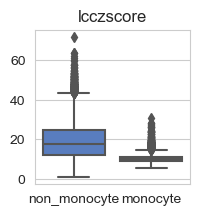

TypeError: Neither the `x` nor `y` variable appears to be numeric.

<Figure size 200x200 with 0 Axes>

In [53]:
lcczscore_result = pd.read_csv(r"E:\00_CeSOP\results\simulation\Healthy-Hematopoiesis-191120-SCPAGWAS-G-ran50.csv")
lcczscore_result.index = lcczscore_result["cell"]
lcczscore_result["Types"] = labels["Types"]
# 遍历所有数值列
for column in lcczscore_result.columns[1:]:
    # 绘制小提琴图
    plt.figure(figsize=(2, 2))
    sns.boxplot(x='Types', y=column, data=lcczscore_result, palette='muted')
    plt.title(f"{column}")
    plt.xlabel('')
    plt.ylabel('')
    plt.show()

In [44]:

lcczscore_result = pd.read_csv(r"E:\00_CeSOP\results\simulation\Healthy-Hematopoiesis-191120-SCPAGWAS.csv")
lcczscore_result.index = lcczscore_result["cell"]

lcczscore_result["Types"] = labels["Types"]

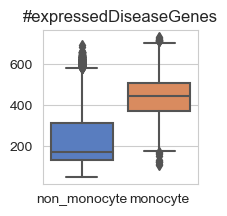

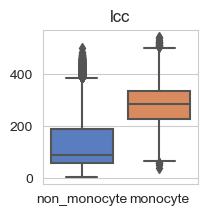

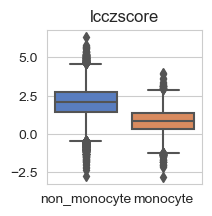

TypeError: Neither the `x` nor `y` variable appears to be numeric.

<Figure size 200x200 with 0 Axes>

In [45]:

# 遍历所有数值列
for column in lcczscore_result.columns[1:]:
    # 绘制小提琴图
    plt.figure(figsize=(2, 2))
    sns.boxplot(x='Types', y=column, data=lcczscore_result, palette='muted')
    plt.title(f"{column}")
    plt.xlabel('')
    plt.ylabel('')
    plt.show()

In [49]:

expressedValue = pd.read_csv(r"E:\00_CeSOP\data\simulation\gene_expression_means.csv")
expressedValue.index = expressedValue["Cell"]
expressedValue.columns = ["Cell","Trait-gene_expression_means","NotTrait-gene_expression_means"]
expressedValue["Types"] = labels["Types"]

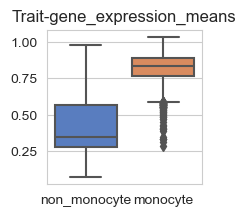

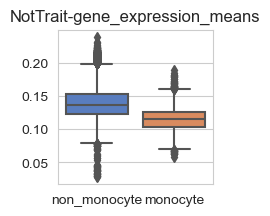

TypeError: Neither the `x` nor `y` variable appears to be numeric.

<Figure size 200x200 with 0 Axes>

In [50]:
# 遍历所有数值列
for column in expressedValue.columns[1:]:
    # 绘制小提琴图
    plt.figure(figsize=(2, 2))
    sns.boxplot(x='Types', y=column, data=expressedValue, palette='muted')
    plt.title(f"{column}")
    plt.xlabel('')
    plt.ylabel('')
    plt.show()

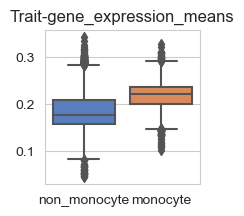

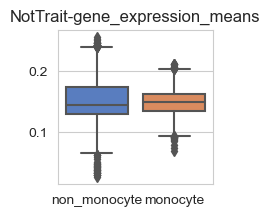

TypeError: Neither the `x` nor `y` variable appears to be numeric.

<Figure size 200x200 with 0 Axes>

In [51]:
expressedValue = pd.read_csv(r"E:\00_CeSOP\data\simulation\perigene_expression_means.csv")
expressedValue.index = expressedValue["Cell"]
expressedValue.columns = ["Cell","Trait-gene_expression_means","NotTrait-gene_expression_means"]
expressedValue["Types"] = labels["Types"]
# 遍历所有数值列
for column in expressedValue.columns[1:]:
    # 绘制小提琴图
    plt.figure(figsize=(2, 2))
    sns.boxplot(x='Types', y=column, data=expressedValue, palette='muted')
    plt.title(f"{column}")
    plt.xlabel('')
    plt.ylabel('')
    plt.show()

## 根据基因在网络中中的重要性计算基因分数，表示与性状的关联程度

In [3]:
'''读取背景网络'''
def openPPI(filename):
    '''
        打开PPI
        文件格式 gene1_name gene1_id gene2_name gene2_id
        返回值：网络[节点是gene name]
    '''
    G = nx.Graph()
    a=open(filename,"r")
    next(a)

    for i in a:
        n=i.strip().split("\t")
        G.add_edge(n[0],n[3])
        G.add_node(n[0])
        G.add_node(n[3])
    a.close()
    return G

G = openPPI(r"E:\00_CeSOP\data\network(process_id).txt")

In [ ]:
# 计算最大连通分支
def Lcc(G,nodes):
    '''
        输入图网络和一个列表，计算最大连通分支lcc
        如果空节点集合，返回0；子图不联通，返回1；否则返回最大连通分支
        G：图，这里图中的节点是基因name
        genename：用于计算lcc的genename列表
    '''

    g = nx.subgraph(G,nodes)
    if len(nodes)==0:
        largest = 0
    else:
        try:
            l = max(nx.connected_components(g),key=len)  #如果随机选取的gene没有连通分支的话，会报错，添加判断条件
            largest = len(l)     #最大联通分支
        except ValueError as e:
            l = nodes[0]    # 假设genename列表中的第一个基因为最大连通分支
            largest = 1        #设置最大联通分支数为1
    return largest

# 计算节点重要性
def nodeImportance(G,nodes):
    '''
    如果一个节点的删除导致了连通分支（或连通组件）的显著分裂，那么这个节点可以被视为一个关键节点或割点（articulation point）
    :param G:
    :return: 节点重要性字典
    '''
    g = G.subgraph(nodes)
    original_max_size = Lcc(g,nodes)
    # 计算节点的重要程度
    node_importance = {}

    for node in nodes:
        # 删除节点后，重新计算lcc
        # 使用列表推导式创建新列表，不包含要移除的元素
        # new_nodes = list(set(nodes) - {node})
            
        new_nodes = [element for element in nodes if element != node]
        new_max_size = Lcc(g,new_nodes)
        node_importance[node] = (original_max_size - new_max_size)/original_max_size
            
    return node_importance

In [8]:
scpawas_genes = pd.read_csv(r"E:\00_CeSOP\data\simulation\scPagwas.BMMC.topgenes.monocytecount.csv")
scpawas_1000_genes = scpawas_genes.loc[0]["genes"]
scpawas_1000_genes_list = [item for item in scpawas_1000_genes.split(',')]
node_importance = nodeImportance(G,scpawas_1000_genes_list)

In [9]:

import csv
# 定义 CSV 文件路径
file_path = r"E:\00_CeSOP\data\simulation\scPagwas.BMMC.topgenes.gene_importance.csv"

# 将字典转换为一个列表，以便写入 CSV
# 将字典的键作为列标题，字典的值作为数据
data_to_write = [{'Gene': key, 'Importance': value} for key, value in node_importance.items()]

# 打开文并写入数据
with open(file_path, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=["Gene", "Importance"])
    
    # 写入表头
    writer.writeheader()
    
    # 写入数据
    writer.writerows(data_to_write)

In [ ]:
labels = pd.read_csv(r"E:\00_CeSOP\data\simulation\Seu_Hema_cell_classification.txt")
labels.index = labels["Cell"]
labels["Types"] = "non_monocyte"
labels.loc[labels["BioClassification"]=="11_CD14.Mono.1","Types"]="monocyte"
labels.loc[labels["BioClassification"]=="12_CD14.Mono.2","Types"]="monocyte"
labels.loc[labels["BioClassification"]=="13_CD16.Monov","Types"]="monocyte"

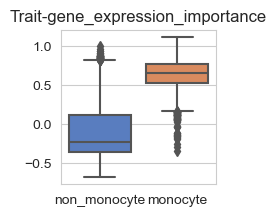

TypeError: Neither the `x` nor `y` variable appears to be numeric.

<Figure size 200x200 with 0 Axes>

In [74]:
expressedValue = pd.read_csv(r"E:\00_CeSOP\data\simulation\gene_importance_expression.csv")
expressedValue.columns = ["Cell","Trait-gene_expression_importance"]
expressedValue.index = expressedValue["Cell"]

expressedValue["Types"] = labels["Types"]
# 遍历所有数值列
for column in expressedValue.columns[1:]:
    # 绘制小提琴图
    plt.figure(figsize=(2, 2))
    sns.boxplot(x='Types', y=column, data=expressedValue, palette='muted')
    plt.title(f"{column}")
    plt.xlabel('')
    plt.ylabel('')
    plt.show()

In [85]:
percent = len(labels[labels["Types"] == "monocyte"])/len(labels)
# 计算前 percent 的阈值
threshold = np.percentile(expressedValue["Trait-gene_expression_importance"], 100 - percent * 100)
expressedValue["pred"]= expressedValue["Trait-gene_expression_importance"].apply(lambda x: "monocyte" if x > threshold else "non_monocyte")

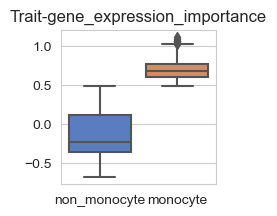

In [90]:
# 绘制小提琴图
plt.figure(figsize=(2, 2))
sns.boxplot(x='pred', y='Trait-gene_expression_importance', data=expressedValue, palette='muted')
plt.title(f"Trait-gene_expression_importance")
plt.xlabel('')
plt.ylabel('')
plt.show()

In [ ]:
## 修改节点重要性的度量方法

In [96]:
g = nx.subgraph(G,scpawas_1000_genes_list)
pagerank = nx.pagerank(g)
# 计算度中心性
degree_centrality = nx.degree_centrality(g)

# 打印结果
print("Degree Centrality:", degree_centrality)

import csv
# 定义 CSV 文件路径
file_path = r"E:\00_CeSOP\data\simulation\scPagwas.BMMC.topgenes.gene_degree_centrality.csv"
# 将字典转换为一个列表，以便写入 CSV
# 将字典的键作为列标题，字典的值作为数据
data_to_write = [{'Gene': key, 'Degree_centrality': value} for key, value in degree_centrality.items()]

# 打开文并写入数据
with open(file_path, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=["Gene", "Degree_centrality"])
    
    # 写入表头
    writer.writeheader()
    
    # 写入数据
    writer.writerows(data_to_write)

Degree Centrality: {'TIMP2': 0.001017293997965412, 'PGK1': 0.007121057985757883, 'CEBPA': 0.01017293997965412, 'HLA-DPB1': 0.003051881993896236, 'FCGR2A': 0.00508646998982706, 'SKAP2': 0.003051881993896236, 'NASP': 0.00508646998982706, 'PPIF': 0.003051881993896236, 'ERCC1': 0.002034587995930824, 'MLEC': 0.001017293997965412, 'NACC2': 0.0, 'GNB1': 0.008138351983723296, 'CD74': 0.006103763987792472, 'MYD88': 0.009155645981688708, 'S100A11': 0.002034587995930824, 'TNFSF10': 0.001017293997965412, 'SLC25A6': 0.017293997965412002, 'SYNCRIP': 0.03051881993896236, 'RAC1': 0.024415055951169887, 'EHBP1L1': 0.0, 'CCR2': 0.002034587995930824, 'ARRB2': 0.04781281790437436, 'QKI': 0.004069175991861648, 'ZDHHC1': 0.001017293997965412, 'PEA15': 0.003051881993896236, 'NCF4': 0.012207527975584944, 'APP': 0.01627670396744659, 'SYNGR1': 0.0, 'MRPL12': 0.006103763987792472, 'LTBR': 0.003051881993896236, 'NFE2': 0.001017293997965412, 'CRISPLD2': 0.001017293997965412, 'PCNA': 0.025432349949135298, 'SDCBP': 0

In [97]:
# 计算接近中心性
closeness_centrality = nx.closeness_centrality(g)
# 打印结果
print("Closeness Centrality:", closeness_centrality)
# 定义 CSV 文件路径
file_path = r"E:\00_CeSOP\data\simulation\scPagwas.BMMC.topgenes.gene_closeness_centrality.csv"

# 将字典转换为一个列表，以便写入 CSV
# 将字典的键作为列标题，字典的值作为数据
data_to_write = [{'Gene': key, 'closeness_centrality': value} for key, value in closeness_centrality.items()]

# 打开文并写入数据
with open(file_path, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=["Gene", "closeness_centrality"])
    
    # 写入表头
    writer.writeheader()
    
    # 写入数据
    writer.writerows(data_to_write)

Closeness Centrality: {'TIMP2': 0.16942113829234726, 'PGK1': 0.2206619273385131, 'CEBPA': 0.23246617725861315, 'HLA-DPB1': 0.18397585907271577, 'FCGR2A': 0.20933399435981304, 'SKAP2': 0.20423529329650372, 'NASP': 0.23690643850350507, 'PPIF': 0.19622474619621236, 'ERCC1': 0.1779808310790159, 'MLEC': 0.19291830199588733, 'NACC2': 0.0, 'GNB1': 0.22533909158187296, 'CD74': 0.187392470871674, 'MYD88': 0.21111556026925823, 'S100A11': 0.2016754335905516, 'TNFSF10': 0.1741796020945899, 'SLC25A6': 0.24899451273915027, 'SYNCRIP': 0.26342738051296827, 'RAC1': 0.25862114681116777, 'EHBP1L1': 0.0, 'CCR2': 0.2166469723287148, 'ARRB2': 0.2817538475907753, 'QKI': 0.2064306102494134, 'ZDHHC1': 0.17362084571575045, 'PEA15': 0.22783998467635216, 'NCF4': 0.23120228347934305, 'APP': 0.25639357448721284, 'SYNGR1': 0.0, 'MRPL12': 0.1886393789478163, 'LTBR': 0.20332851091506432, 'NFE2': 0.2030511186764353, 'CRISPLD2': 0.15351879318187422, 'PCNA': 0.25205160032146834, 'SDCBP': 0.2422074369240473, 'RALBP1': 0.2

In [98]:
# 计算介数中心性
betweenness_centrality = nx.betweenness_centrality(g)
# 打印结果
print("Betweenness Centrality:", betweenness_centrality)
# 定义 CSV 文件路径
file_path = r"E:\00_CeSOP\data\simulation\scPagwas.BMMC.topgenes.gene_betweenness_centrality.csv"

# 将字典转换为一个列表，以便写入 CSV
# 将字典的键作为列标题，字典的值作为数据
data_to_write = [{'Gene': key, 'betweenness_centrality': value} for key, value in betweenness_centrality.items()]

# 打开文并写入数据
with open(file_path, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=["Gene", "betweenness_centrality"])
    
    # 写入表头
    writer.writeheader()
    
    # 写入数据
    writer.writerows(data_to_write)

Betweenness Centrality: {'TIMP2': 0.0, 'PGK1': 0.0017886394197719753, 'CEBPA': 0.001120416388693255, 'HLA-DPB1': 0.00037528044667994084, 'FCGR2A': 0.00298196865847391, 'SKAP2': 5.381199667053595e-05, 'NASP': 0.002441770128382073, 'PPIF': 0.0016142405990120263, 'ERCC1': 0.0, 'MLEC': 0.0, 'NACC2': 0.0, 'GNB1': 0.0009998304948173966, 'CD74': 0.005500640605835935, 'MYD88': 0.004946201714687378, 'S100A11': 1.77633853820312e-05, 'TNFSF10': 0.0, 'SLC25A6': 0.007221277670191842, 'SYNCRIP': 0.01763084951290106, 'RAC1': 0.012365865836078951, 'EHBP1L1': 0.0, 'CCR2': 2.450047847017405e-05, 'ARRB2': 0.025509796211476848, 'QKI': 0.0016208318193496201, 'ZDHHC1': 0.0, 'PEA15': 2.6810974036005968e-05, 'NCF4': 0.0018290750587663935, 'APP': 0.008600740540219224, 'SYNGR1': 0.0, 'MRPL12': 0.002970041940245442, 'LTBR': 0.0006809102691373092, 'NFE2': 0.0, 'CRISPLD2': 0.0, 'PCNA': 0.007511702518907574, 'SDCBP': 0.019139829277867636, 'RALBP1': 0.00043468838657131686, 'NCOA4': 0.00011863292104958916, 'EVI2A': 0

In [99]:
# 计算特征向量中心性
eigenvector_centrality = nx.eigenvector_centrality(g)

# 打印结果
print("Eigenvector Centrality:", eigenvector_centrality)
# 定义 CSV 文件路径
file_path = r"E:\00_CeSOP\data\simulation\scPagwas.BMMC.topgenes.gene_eigenvector_centrality.csv"

# 将字典转换为一个列表，以便写入 CSV
# 将字典的键作为列标题，字典的值作为数据
data_to_write = [{'Gene': key, 'eigenvector_centrality': value} for key, value in eigenvector_centrality.items()]

# 打开文并写入数据
with open(file_path, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=["Gene", "eigenvector_centrality"])
    
    # 写入表头
    writer.writeheader()
    
    # 写入数据
    writer.writerows(data_to_write)

Eigenvector Centrality: {'TIMP2': 0.0007301666564941629, 'PGK1': 0.016886612727018756, 'CEBPA': 0.027531955832707556, 'HLA-DPB1': 0.0015584343851703264, 'FCGR2A': 0.008281631895579988, 'SKAP2': 0.005115495443555823, 'NASP': 0.018244193358085237, 'PPIF': 0.006602188210547311, 'ERCC1': 0.0010360171456509394, 'MLEC': 0.003396495529500145, 'NACC2': 2.50949163541996e-26, 'GNB1': 0.018713795605474707, 'CD74': 0.0012987735362003268, 'MYD88': 0.008736302746891586, 'S100A11': 0.008532894407175457, 'TNFSF10': 0.0010036036809466862, 'SLC25A6': 0.07283970496321679, 'SYNCRIP': 0.09238039820623828, 'RAC1': 0.06148313989590214, 'EHBP1L1': 2.50949163541996e-26, 'CCR2': 0.012993247280636559, 'ARRB2': 0.1935274999598891, 'QKI': 0.009337914916728805, 'ZDHHC1': 0.0006138086008254819, 'PEA15': 0.018304541634001126, 'NCF4': 0.022229775896811892, 'APP': 0.060045661653780724, 'SYNGR1': 2.50949163541996e-26, 'MRPL12': 0.0022286047402084617, 'LTBR': 0.0036204666573889863, 'NFE2': 0.005647945700356598, 'CRISPLD2

In [100]:
# 计算接近中心性
closeness_centrality = nx.closeness_centrality(g)
# 计算 PageRank
pagerank = nx.pagerank(g)
# 计算特征向量中心性
eigenvector_centrality = nx.eigenvector_centrality(g)
# 计算介数中心性
betweenness_centrality = nx.betweenness_centrality(g)

degree_centrality = nx.degree_centrality(g)

# 打印结果
print("PageRank:", pagerank)
# 定义 CSV 文件路径
file_path = r"E:\00_CeSOP\data\simulation\scPagwas.BMMC.topgenes.gene_pagerank.csv"

# 将字典转换为一个列表，以便写入 CSV
# 将字典的键作为列标题，字典的值作为数据
data_to_write = [{'Gene': key, 'pagerank': value} for key, value in pagerank.items()]

# 打开文并写入数据
with open(file_path, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=["Gene", "pagerank"])
    
    # 写入表头
    writer.writeheader()
    
    # 写入数据
    writer.writerows(data_to_write)

PageRank: {'TIMP2': 0.0003310536510797256, 'PGK1': 0.0011771396787399876, 'CEBPA': 0.0016827344891708462, 'HLA-DPB1': 0.0007435132489744435, 'FCGR2A': 0.0011311678377055189, 'SKAP2': 0.0006997135944107795, 'NASP': 0.0009671636066934359, 'PPIF': 0.0008511416872641056, 'ERCC1': 0.000570950663079905, 'MLEC': 0.00033838853979290765, 'NACC2': 0.00018427518429274208, 'GNB1': 0.0014194406359863145, 'CD74': 0.001535339336585078, 'MYD88': 0.0022033221172306095, 'S100A11': 0.0004834001113843417, 'TNFSF10': 0.0003791237673083244, 'SLC25A6': 0.0027631268214052154, 'SYNCRIP': 0.004618403748311803, 'RAC1': 0.004027802756897079, 'EHBP1L1': 0.00018427518429274208, 'CCR2': 0.00045982312873227906, 'ARRB2': 0.00712174460055418, 'QKI': 0.000910451083681197, 'ZDHHC1': 0.0004277273444159712, 'PEA15': 0.0006083449995642758, 'NCF4': 0.0020069182216695958, 'APP': 0.00278360114512193, 'SYNGR1': 0.00018427518429274208, 'MRPL12': 0.0015634450200960625, 'LTBR': 0.0006813660974341407, 'NFE2': 0.0003255337453762203,

In [102]:

# 计算子图中心性
subgraph_centrality = nx.subgraph_centrality(g)
# 归一化子图中心性
min_centrality = min(subgraph_centrality.values())
max_centrality = max(subgraph_centrality.values())
# 归一化公式
normalized_subgraph_centrality = {node: (centrality - min_centrality) / (max_centrality - min_centrality)
                                  for node, centrality in subgraph_centrality.items()}
# 打印归一化后的子图中心性
print("Normalized Subgraph Centrality:", normalized_subgraph_centrality)

# 定义 CSV 文件路径
file_path = r"E:\00_CeSOP\data\simulation\scPagwas.BMMC.topgenes.gene_subgraph_centrality.csv"

# 将字典转换为一个列表，以便写入 CSV
# 将字典的键作为列标题，字典的值作为数据
data_to_write = [{'Gene': key, 'subgraph_centrality': value} for key, value in normalized_subgraph_centrality.items()]

# 打开文并写入数据
with open(file_path, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=["Gene", "subgraph_centrality"])    
    # 写入表头
    writer.writeheader()    
    # 写入数据
    writer.writerows(data_to_write)

Normalized Subgraph Centrality: {'TIMP2': 9.085969220510482e-06, 'PGK1': 0.004338014920299754, 'CEBPA': 0.011463410401283953, 'HLA-DPB1': 3.780344005927112e-05, 'FCGR2A': 0.0010470378018028273, 'SKAP2': 0.00040133437442878864, 'NASP': 0.005039698856919024, 'PPIF': 0.0006608533701535489, 'ERCC1': 1.6648302570596328e-05, 'MLEC': 0.00017427180807103956, 'NACC2': 2.2891154567916846e-22, 'GNB1': 0.005284258306323166, 'CD74': 2.7463870435458182e-05, 'MYD88': 0.001163384653112122, 'S100A11': 0.0011018040238234827, 'TNFSF10': 1.5363650461894588e-05, 'SLC25A6': 0.08030367107917913, 'SYNCRIP': 0.12926089643587776, 'RAC1': 0.05741690379549035, 'EHBP1L1': 7.043432174743645e-23, 'CCR2': 0.0025444126118115556, 'ARRB2': 0.5642865833784442, 'QKI': 0.0013302005727746464, 'ZDHHC1': 5.952325824464121e-06, 'PEA15': 0.005066439310673391, 'NCF4': 0.007492300333873508, 'APP': 0.05432159812506126, 'SYNGR1': 2.2891154567916846e-22, 'MRPL12': 7.661895613969492e-05, 'LTBR': 0.0002015463717800602, 'NFE2': 0.00048

In [ ]:
# 计算子图中心性
subgraph_centrality = nx.subgraph_centrality(g)
# 归一化子图中心性
min_centrality = min(subgraph_centrality.values())
max_centrality = max(subgraph_centrality.values())
# 归一化公式
normalized_subgraph_centrality = {node: (centrality - min_centrality) / (max_centrality - min_centrality)
                                  for node, centrality in subgraph_centrality.items()}

In [116]:
### 基于外围基因计算节点重要性

In [117]:
t = 12

perigenes = list(pd.read_csv(r"E:\00_CeSOP\data\core_peri_geneset_of_49_traits\periphery\%s.txt"%(t+1),sep = "\t",header= None)[0])
interest_genes = perigenes
g = nx.subgraph(G,interest_genes)


In [118]:
pagerank = nx.pagerank(g)

import csv
# 定义 CSV 文件路径
file_path = r"E:\00_CeSOP\data\simulation\Perigenes.BMMC.pagerank.csv"
# 将字典转换为一个列表，以便写入 CSV
# 将字典的键作为列标题，字典的值作为数据
data_to_write = [{'Gene': key, 'Value': value} for key, value in pagerank.items()]
# 打开文并写入数据
with open(file_path, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=["Gene", "Value"])
    # 写入表头
    writer.writeheader()
    # 写入数据
    writer.writerows(data_to_write)

In [120]:
# 计算子图中心性

subgraph_centrality = nx.subgraph_centrality(g)
# 归一化子图中心性
min_centrality = min(subgraph_centrality.values())
max_centrality = max(subgraph_centrality.values())
# 归一化公式
normalized_subgraph_centrality = {node: (centrality - min_centrality) / (max_centrality - min_centrality)
                                  for node, centrality in subgraph_centrality.items()}

# 定义 CSV 文件路径
file_path = r"E:\00_CeSOP\data\simulation\Perigenes.gene_subgraph_centrality.csv"

# 将字典转换为一个列表，以便写入 CSV
# 将字典的键作为列标题，字典的值作为数据
data_to_write = [{'Gene': key, 'Value': value} for key, value in normalized_subgraph_centrality.items()]

# 打开文并写入数据
with open(file_path, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=["Gene", "Value"])    
    # 写入表头
    writer.writeheader()    
    # 写入数据
    writer.writerows(data_to_write)

In [121]:
# 计算接近中心性
closeness_centrality = nx.closeness_centrality(g)
# 计算特征向量中心性
eigenvector_centrality = nx.eigenvector_centrality(g)
# 计算介数中心性
betweenness_centrality = nx.betweenness_centrality(g)
# 计算度中心性
degree_centrality = nx.degree_centrality(g)


In [122]:
def write_toCsv(file_path,centrality):
    # 将字典的键作为列标题，字典的值作为数据
    data_to_write = [{'Gene': key, 'Value': value} for key, value in centrality.items()]
    # 打开文并写入数据
    with open(file_path, mode='w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=["Gene", "Value"])    
        # 写入表头
        writer.writeheader()    
        # 写入数据
        writer.writerows(data_to_write)

In [123]:
file_path = r"E:\00_CeSOP\data\simulation\Perigenes.gene_degree_centrality.csv"
write_toCsv(file_path,degree_centrality)

In [124]:
file_path = r"E:\00_CeSOP\data\simulation\Perigenes.gene_eigenvector_centrality.csv"
write_toCsv(file_path,eigenvector_centrality)

In [125]:
file_path = r"E:\00_CeSOP\data\simulation\Perigenes.gene_closeness_centrality.csv"
write_toCsv(file_path,closeness_centrality)

In [126]:
file_path = r"E:\00_CeSOP\data\simulation\Perigenes.gene_betweenness_centrality.csv"
write_toCsv(file_path,betweenness_centrality)

In [128]:
node_importance = nodeImportance(G,interest_genes)
file_path = r"E:\00_CeSOP\data\simulation\Perigenes.BMMC.gene_importance.csv"
write_toCsv(file_path,node_importance)